In [1]:
print("""Feedback from Brian:
1) Filter using nms 0.4 label column(Use only if TRUE, greater than 0.4) --DONE
2) Plot boxplots with more than 5 datapoints --DONE
3) Combine to put all ephys features in one plot -- NOT SURE HOW?

*Use Tree call column when you have a large dataset
*Use NMS for smaller dataset now""")

##### Imports 

In [2]:
import pandas as pd
import numpy as np
import csv
import logging
from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "ticks", font="verdana") # font_scale = 1.35)

##### Logging Set-up

In [3]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

##### Pandas Display Settings

In [4]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Lists/Paths

In [5]:
csv_path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/csv/"
excel_path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/excel/"
plot_path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/plot/"

In [6]:
fields_jem = ["date", "organism_name", "container", "rigOperator", "status", "roi"]
              #"extraction.postPatch", "extraction.endPipetteR"]
fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]
fields_shiny = ["patch.date", "cell_name", "sample_id", "cell_specimen_project",
                "subclass_label", "broad_class_label",
                "marker_sum_norm_label", "Norm_Marker_Sum.0.4_label"] #"Tree_call", "topLeaf_label"

In [7]:
path_jem = "C:/Users/kumar/Documents/GitHub/analysis_projects/analysis_scripts/csv/jem_metadata_wFAILURE.csv"
path_ephys = "C:/Users/kumar/Documents/GitHub/analysis_projects/analysis_scripts/csv/ephys_mIVSCC_MET.csv"
path_shiny = "C:/Users/kumar/Documents/GitHub/analysis_projects/analysis_scripts/csv/Mouse_VISp_ctx_shiny.csv"

In [8]:
drop_nans_list = ["date"]
drop_cols_list = ["sample_id", "patch.date", "status", "name", "cell_specimen_project", "organism_name"]

In [9]:
b_colors={"RSP": "#a1d99b", "VISp": "#9ecae1"}
s_colors={"RSP": "#41ab5d", "VISp": "#4292c6"}

##### Main

In [10]:
def main():
    global jem, shiny, ephys, merge_sj, merge_all, merge_all_glu, merge_all_gab, rsp_glu, visp_glu, rsp_visp_glu
    jem = read_file(path_jem, fields_jem) #20843 rows
    ephys = read_file(path_ephys, fields_ephys) #8541 rows
    shiny = read_file(path_shiny, fields_shiny) #10674 rows

    jem = filter_df(jem, "status", "SUCCESS") #13325 rows
    jem = filter_date_range(jem, "date") #6335 rows
    
    shiny = filter_df(shiny, "Norm_Marker_Sum.0.4_label", True) #9101 rows
    shiny = filter_date_range(shiny, "patch.date") #2849 rows

    merge_sj = merge_dataframes(shiny, jem, "sample_id", "container", "inner") #2850 rows (even if how=left)
    merge_all = merge_dataframes(merge_sj, ephys, "cell_name", "name", "inner") #2635 rows

    merge_all = drop_nans(merge_all, drop_nans_list)
    merge_all = drop_cols(merge_all, drop_cols_list)
    merge_all = create_container_col(merge_all, "rigOperator")
    merge_all.set_index("date", inplace=True)
    
    merge_all["region"] = pd.np.where(merge_all.roi.str.contains("RSP"), "RSP", 
                                      pd.np.where(merge_all.roi.str.contains("VISp"), "VISp", 
                                      pd.np.where(merge_all.roi.str.contains("TEa"), "TEa",
                                      pd.np.where(merge_all.roi.str.contains("CTXsp"), "CLA",
                                      pd.np.where(merge_all.roi.str.contains("MO"), "MO",
                                      pd.np.where(merge_all.roi.str.contains("ORB"), "ORB",
                                      pd.np.where(merge_all.roi.str.contains("SSp"), "SSp",
                                      pd.np.where(merge_all.roi.str.contains("HY"), "HY", "Unknown"))))))))
    
    merge_all_glu = create_cond_df(merge_all, "broad_class_label", ["Glutamatergic"])
    merge_all_gab = create_cond_df(merge_all, "broad_class_label", ["GABAergic"])

    rsp_glu = create_cond_df(merge_all_glu, "region", ["RSP"])
    visp_glu = create_cond_df(merge_all_glu, "region", ["VISp"])
    rsp_visp_glu = pd.concat([rsp_glu, visp_glu])

In [11]:
if __name__ == "__main__":
    main()

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Filtered dataframe based on status == SUCCESS
C:\Users\kumar\Documents\Github\analysis_projects\analysis_scripts\functions\temp_funcs.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values([date_col], inplace=True)
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Filtered dataframe based on Norm_Marker_Sum.0.4_label == True
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INF

##### Writing to Excel File

In [12]:
writer = pd.ExcelWriter(excel_path + "mephys_final_home.xlsx")
rsp_visp_glu.to_excel(writer, "RSP_VISP_Glu", freeze_panes=(1,0))
rsp_glu.to_excel(writer, "RSP_Glu", freeze_panes=(1,0))
visp_glu.to_excel(writer, "VISP_Glu", freeze_panes=(1,0))
merge_all.to_excel(writer, "All", freeze_panes=(1,0))
merge_sj.to_excel(writer, "Shiny_Jem", freeze_panes=(1,0))
shiny.to_excel(writer, "Shiny", freeze_panes=(1,0))
jem.to_excel(writer, "Jem", freeze_panes=(1,0))
ephys.to_excel(writer, "Ephys", freeze_panes=(1,0))
writer.save()

##### Misc Info

In [13]:
#merge_all #2787 rows
#merge_all_glu #1583 rows
#merge_all_gab #1204 rows

In [14]:
rsp_visp_glu.reset_index(inplace=True)
rsp_visp_glu.sort_values(["subclass_label"], inplace=True)
rsp_glu.sort_values(["subclass_label"], inplace=True)
visp_glu.sort_values(["subclass_label"], inplace=True)

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [15]:
#rsp_visp_glu #1424 rows
#Start Date: 1.04.2019 
#End Date: 1.31.2020
#rsp_visp_glu

In [16]:
#rsp_glu.replace({"roi_major": {"RSPd": "RSP", "RSPv": "RSP"}}, inplace=True)
#mo_glu.replace({"roi_major": {"MOp": "MO", "MOs": "MO"}}, inplace=True)

In [17]:
"""
region_dict = {"Overall Mouse Total count": merge_all.name.count(),
               "RSP Total": rsp.name.count(),
               "SSp Total": ssp.name.count(),
               "ORB Total": orb.name.count(),
               "CTXsp Total": ctxsp.name.count(),
               "MO Total": mo.name.count(),
               "VISp Total": visp.name.count()}

glu_dict = {"Glutamatergic Mouse Total count": merge_all_glu.name.count(),
            "RSP": rsp_glu.name.count(),
            "SSp": ssp_glu.name.count(),
            "ORB": orb_glu.name.count(),
            "CTXsp": ctxsp_glu.name.count(),
            "MO": mo_glu.name.count(),
            "VISp": visp_glu.name.count()}

gab_dict = {"GABAergic Mouse Total count": merge_all_gab.name.count(),
            "RSP": rsp_gab.name.count(),
            "SSp": ssp_gab.name.count(),
            "ORB": orb_gab.name.count(),
            "CTXsp": ctxsp_gab.name.count(),
            "MO": mo_gab.name.count(),
            "VISp": visp_gab.name.count()}

for k,v in region_dict.items():
    print(f"{k} : {v}")
    
for k,v in glu_dict.items():
    print(f"{k} : {v}")

for k,v in gab_dict.items():
    print(f"{k} : {v}")
"""

'\nregion_dict = {"Overall Mouse Total count": merge_all.name.count(),\n               "RSP Total": rsp.name.count(),\n               "SSp Total": ssp.name.count(),\n               "ORB Total": orb.name.count(),\n               "CTXsp Total": ctxsp.name.count(),\n               "MO Total": mo.name.count(),\n               "VISp Total": visp.name.count()}\n\nglu_dict = {"Glutamatergic Mouse Total count": merge_all_glu.name.count(),\n            "RSP": rsp_glu.name.count(),\n            "SSp": ssp_glu.name.count(),\n            "ORB": orb_glu.name.count(),\n            "CTXsp": ctxsp_glu.name.count(),\n            "MO": mo_glu.name.count(),\n            "VISp": visp_glu.name.count()}\n\ngab_dict = {"GABAergic Mouse Total count": merge_all_gab.name.count(),\n            "RSP": rsp_gab.name.count(),\n            "SSp": ssp_gab.name.count(),\n            "ORB": orb_gab.name.count(),\n            "CTXsp": ctxsp_gab.name.count(),\n            "MO": mo_gab.name.count(),\n            "VISp": vi

##### Plot Functions

In [18]:
rsub_list = []
rless_list = []
for n in rsp_glu.subclass_label.unique():
    ex = rsp_glu[rsp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        rsub_list.append(n)
    else:
        rless_list.append(n)

vsub_list = []
vless_list = []
for n in visp_glu.subclass_label.unique():
    ex = visp_glu[visp_glu["subclass_label"] == n]
    value = ex["vrest"].count() > 5
    if value == True:
        vsub_list.append(n)
    else:
        vless_list.append(n)
        
#print(f"This list has greater than 5 datapoints: {rsub_list}")
#print(f"This list has less than 5 datapoints: {rless_list}")
#print(f"This list has greater than 5 datapoints: {vsub_list}")
#print(f"This list has less than 5 datapoints: {vless_list}")

sub_list = list(set(rsub_list) & set(vsub_list))
print(f"Combined subclass list(greater than 5 datapoints): {sub_list}")

Combined subclass list(greater than 5 datapoints): ['L2 IT RSP-ACA', 'L5 ET CTX', 'L5 NP CTX']


In [19]:
def box_plt(col_y, jpg_title, plt_title, ylim_min, ylim_max, df=rsp_visp_glu):
    """Creates a box plot using seaborn and compares the ephys features between
    two mouse regions while displaying the t-types.
    Args:
        col_y(string): y-axis column
        jpg_title(string): title of the jpeg file
        plt_tile(string): title of the plot
        df: a pandas dataframe
    Returns: None
    """
    fig_dims = (5, 8)
    f, axes = plt.subplots(figsize=fig_dims)

    ax = sns.boxplot(x="subclass_label", y=col_y, hue="region", data=df[df[col_y] < ylim_max],
                     order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                     hue_order = ["RSP", "VISp"],
                     palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False)

    ax = sns.stripplot(x="subclass_label", y=col_y, hue="region", data=df[df[col_y] < ylim_max],
                       order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                       hue_order = ["RSP", "VISp"],
                       jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5)
    
    #sns.despine(trim=True)
    handles, labels = ax.get_legend_handles_labels()
    l = plt.legend(handles[0:2], labels[0:2], title="Region")
    
    #ax.legend_.remove()
    plt.xticks(rotation=90)
    ax.set(xlabel="Subclass", ylabel=plt_title)
    ax.set(ylim=(ylim_min, ylim_max))
    plt.savefig(plot_path + "box_plt_" + jpg_title + ".jpeg", bbox_inches="tight")

##### Plot Outputs

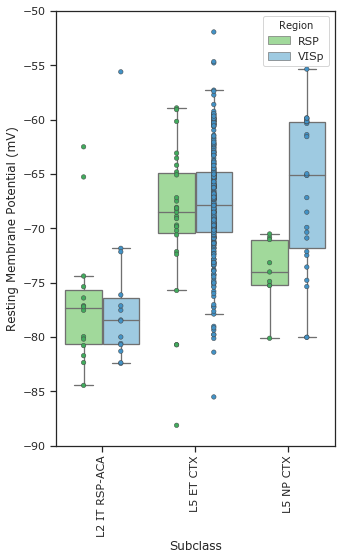

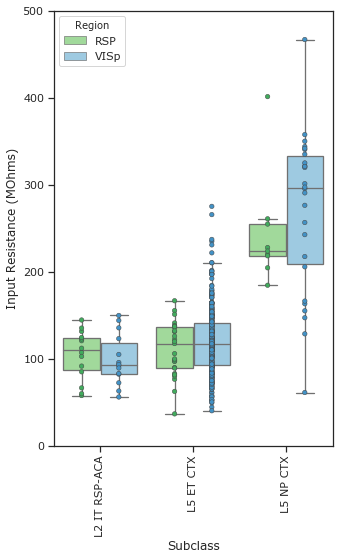

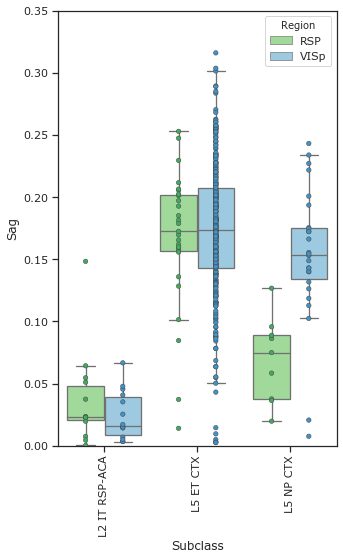

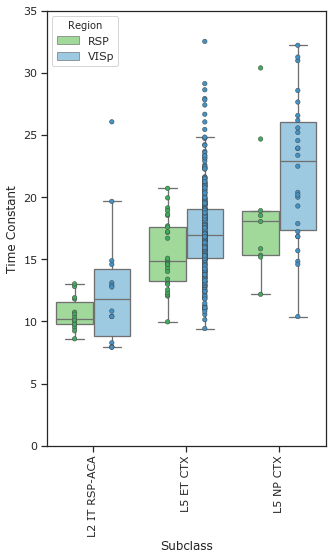

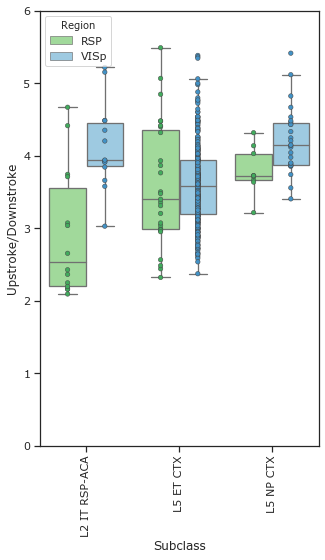

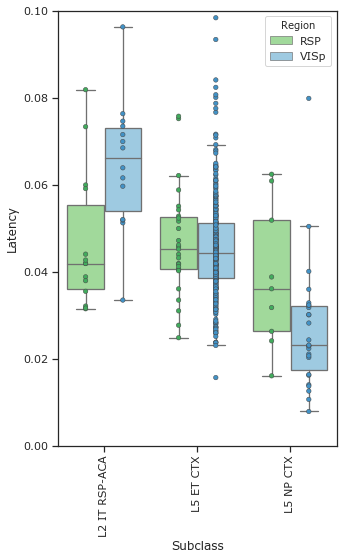

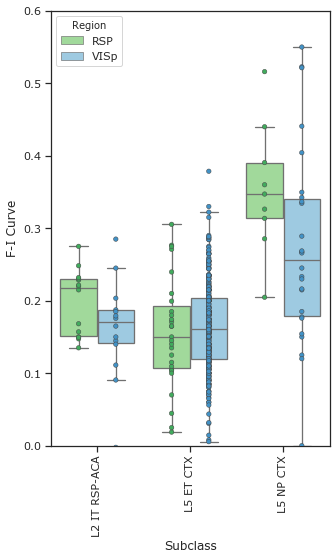

In [20]:
box_plt("vrest", "rmp", "Resting Membrane Potential (mV)", -90, -50)
box_plt("ri", "rin", "Input Resistance (MOhms)", 0, 500)
box_plt("sag", "sag", "Sag", 0, 0.35)
box_plt("tau", "tau", "Time Constant", 0, 35)
box_plt("upstroke_downstroke_ratio_long_square", "udr", "Upstroke/Downstroke", 0, 6)
box_plt("latency", "lat", "Latency", 0, 0.10)
box_plt("f_i_curve_slope", "fis", "F-I Curve", 0, 0.60)

[(0, 0.35)]

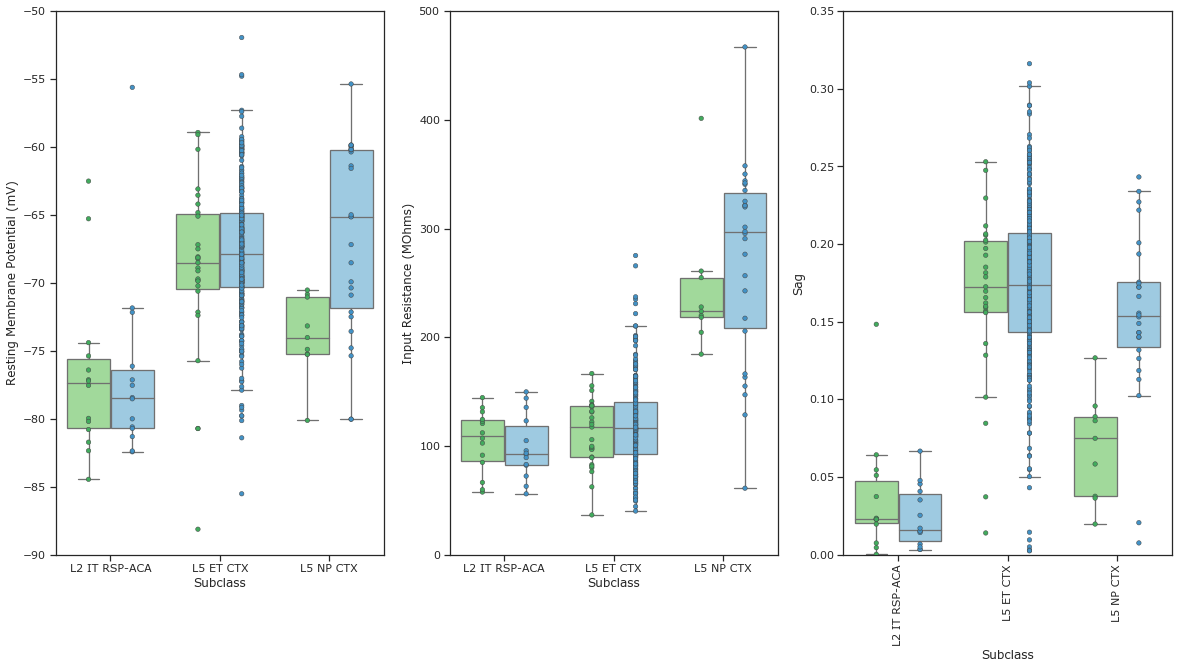

In [33]:
fig_dims = (20, 10)
f, axes = plt.subplots(nrows=1, ncols=3, figsize=fig_dims)


ax = sns.boxplot(x="subclass_label", y="vrest", hue="region", data=rsp_visp_glu[rsp_visp_glu["vrest"] < -50],
                 order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                 hue_order = ["RSP", "VISp"],
                 palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[0])


ax = sns.stripplot(x="subclass_label", y="vrest", hue="region", data=rsp_visp_glu[rsp_visp_glu["vrest"] < -50],
                   order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                   hue_order = ["RSP", "VISp"],
                   jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[0])


ax1 = sns.boxplot(x="subclass_label", y="ri", hue="region", data=rsp_visp_glu[rsp_visp_glu["ri"] < 500],
                 order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                 hue_order = ["RSP", "VISp"],
                 palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[1])

ax1 = sns.stripplot(x="subclass_label", y="ri", hue="region", data=rsp_visp_glu[rsp_visp_glu["ri"] < 500],
                   order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                   hue_order = ["RSP", "VISp"],
                   jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[1])


ax2 = sns.boxplot(x="subclass_label", y="sag", hue="region", data=rsp_visp_glu[rsp_visp_glu["sag"] < 0.35],
                 order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                 hue_order = ["RSP", "VISp"],
                 palette=b_colors, saturation=1, width=0.8, linewidth=1.3, showfliers=False, ax=axes[2])

ax2 = sns.stripplot(x="subclass_label", y="sag", hue="region", data=rsp_visp_glu[rsp_visp_glu["sag"] < 0.35],
                   order = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"],
                   hue_order = ["RSP", "VISp"],
                   jitter=False, size=4.5, palette=s_colors, dodge=True, linewidth=0.5, ax=axes[2])



#sns.despine(trim=True)
#handles, labels = ax.get_legend_handles_labels()
#l = plt.legend(handles[0:2], labels[0:2], title="Region")

ax.legend_.remove()
ax1.legend_.remove()
ax2.legend_.remove()
plt.xticks(rotation=90)

ax.set(xlabel="Subclass", ylabel="Resting Membrane Potential (mV)")
ax1.set(xlabel="Subclass", ylabel="Input Resistance (MOhms)")
ax2.set(xlabel="Subclass", ylabel="Sag")
ax.set(ylim=(-90, -50))
ax1.set(ylim=(0, 500))
ax2.set(ylim=(0, 0.35))